# **Signal reconstruction task (Encoder-Decoder vs Denoiser)**

In [1]:
import pickle
import matplotlib.pyplot as plt
import os

In [2]:
with open('./Data/Unimpaired_diff_BW_mod22.pickle', 'rb') as f:
    data = pickle.load(f, encoding='latin1')

print(data.keys())

dict_keys(['32apsk', '2fsk', 'cpfsk', '64apsk', 'ook', 'qam64', 'oqpsk', 'qpsk', '8psk', '16psk', 'gmsk', 'qam256', '4fsk', 'pam4', '16apsk', 'qam32', 'bpsk', '128apsk', '256apsk', '32psk', 'qam16', 'gfsk'])


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision.transforms import Compose, Lambda

import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
class IQ2TargetDataset(Dataset):
    def __init__(self, data, target, metadata=None, data_transform=None, target_transform=None):
        self.data = data
        self.target = target
        self.metadata = metadata
        self.data_transform = data_transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]
        target = self.target[idx]
        if self.data_transform:
            data = self.data_transform(data)
        elif isinstance(data, np.ndarray):
            data = torch.from_numpy(data).float()

        if self.target_transform:
            target = self.target_transform(target)
        elif isinstance(target, np.ndarray):
            target = torch.from_numpy(target).float()
        return data, target, idx

    def get_metadata(self, idx):
        if self.metadata is None:
            return
        return self.metadata[idx]

In [6]:
labels = data.keys()
X = np.concatenate([data[label] for label in labels])
y = X.copy()  # clean signal with out impairments
metadata = np.concatenate([np.ones(data[label].shape[0]) *
                           i for i, label in enumerate(labels)])
X.shape, y.shape, metadata.shape

((219912, 2, 128), (219912, 2, 128), (219912,))

In [7]:
# split dataset into training and testing to compare the performance of both models
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
train_idx, test_idx = next(sss.split(X, metadata))

**Impairments with be programmatically added to measure the impact on training the model**

We will experiment with the following impairments

- AWGN
- Rayleigh channel fading effects
- Rician channel effects
- Watterson channel effects
- Phase shifts
- Phase noise
- Gain flunctations
- IQ imbalance
- Amplitude compression
- Doppler effect with multipath
- Doppler effect


In [8]:
class RandomAddNoise(nn.Module):
    def __init__(self, min_snr_db=-20, max_snr_db=20):
        super(RandomAddNoise, self).__init__()
        self.min_snr_db, self.max_snr_db = min_snr_db, max_snr_db

    def forward(self, x):
        signal_power = torch.mean(x ** 2)
        signal_power_db = 10 * torch.log10(signal_power)
        noise_power_db = torch.empty_like(signal_power_db).uniform_(
            self.min_snr_db, self.max_snr_db)
        noise_power = 10 ** (noise_power_db / 10)
        noise = torch.randn_like(x) * torch.sqrt(noise_power)
        return x + noise


def _generate_rayleigh_filter_taps(sample_rate, num_path_delays, max_delay, max_amplitude):
    length = int(sample_rate*max_delay)

    g = np.zeros(length)

    # Randomly generate path delays and amplitudes
    t = np.random.uniform(0, max_delay, size=num_path_delays)
    # is uniform right for this??
    a = np.random.uniform(0, max_amplitude, size=num_path_delays)

    Ts = 1/sample_rate

    for n in range(length):
        for k in range(num_path_delays):
            g[n] = g[n] + a[k]*np.sinc((t[k]/Ts)-n)

    return g


class RayleighFading(nn.Module):
    def __init__(self, sir_db=20, max_delay=2.6e-6, num_path_delays=5):
        super(RayleighFading, self).__init__()
        self.sir = 10 ** (sir_db / 10)
        self.max_delay = max_delay
        self.impulse_response = _generate_rayleigh_filter_taps(
            1, num_path_delays, 1e-6, 1.0)

    def forward(self, x):
        intf_power = torch.sum(self.impulse_response)
        impulse_response = (self.impulse_response / intf_power) / self.sir
        impulse_response[0] = 1.0
        return torch.from_numpy(np.convolve(x, impulse_response, 'same'))

In [9]:
Denoiser_data_txfm = Compose([
    Lambda(lambda x: torch.tensor(x).float()),
    RandomAddNoise(),
    Lambda(lambda x: x.unsqueeze(0))  # add feature dimension
])

Denoiser_target_txfm = Compose([
    Lambda(lambda x: torch.tensor(x).float()),
    Lambda(lambda x: x.unsqueeze(0))  # add feature dimension
])

dataset = IQ2TargetDataset(
    X[train_idx], y[train_idx],
    metadata[train_idx], data_transform=Denoiser_data_txfm, target_transform=Denoiser_target_txfm)
train_ds, val_ds = random_split(
    dataset, [int(len(dataset)*0.8), len(dataset)-int(len(dataset)*0.8)])
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

In [10]:
# let's see what the data looks like
xb, yb, idx = next(iter(train_loader))
xb.shape, yb.shape

(torch.Size([32, 1, 2, 128]), torch.Size([32, 1, 2, 128]))

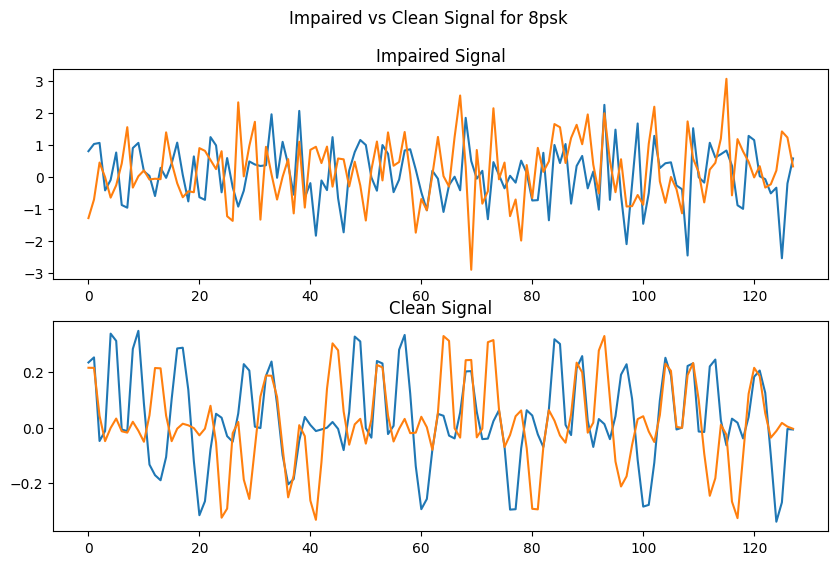

In [11]:
one_X = xb[0].squeeze().numpy()
one_y = yb[0].squeeze().numpy()


fig = plt.figure(figsize=(10, 6))
fig.suptitle('Impaired vs Clean Signal for ' +
             str(list(labels)[int(dataset.get_metadata(idx[0]))]))
ax = fig.add_subplot(211)
ax.title.set_text('Impaired Signal')
ax.plot(one_X.T)
ax = fig.add_subplot(212)
ax.plot(one_y.T)
ax.title.set_text('Clean Signal')

## **Denoiser Arch**

In [12]:
# denoiser module is given by the following equations
# y = {0, if |x| <= tau, sgn(x) * (|x| - tau), otherwise}
# where tau is the threshold value given as 2 * beta
# beta is output of the global average pooling layer
# architecture is adapted from https://doi.org/10.36227/techrxiv.23632308.v1

class thresholdModule(nn.Module):
    def __init__(self, in_feat=16, hidden_feat=256):
        super(thresholdModule, self).__init__()
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(in_feat, hidden_feat)
        self.bn = nn.BatchNorm1d(hidden_feat)
        self.fc2 = nn.Linear(hidden_feat, in_feat)

    def forward(self, x):  # B x feat x 2 x 128
        # B x feat x 1 x 1 -> B x feat
        tau = self.gap(x).squeeze(-1).squeeze(-1)
        tau = F.relu(self.fc1(tau))  # B x 256
        tau = self.bn(tau)  # B x 256
        tau = 2 * F.sigmoid(self.fc2(tau))  # B x feat
        tau = tau.unsqueeze(-1).unsqueeze(-1)  # B x feat x 1 x 1
        y = torch.where(torch.abs(x) <= tau, torch.tensor(0.0),
                        torch.sign(x) * (torch.abs(x) - tau))
        return y


class Denoiser(nn.Module):
    def __init__(self, in_feat=1, hidden_feat=16, n_chan=2, seq_len=128):
        super(Denoiser, self).__init__()
        self.bn = nn.BatchNorm2d(in_feat)
        self.conv1 = nn.Conv2d(in_feat, hidden_feat,
                               kernel_size=(n_chan, 3), padding="same")
        self.threshold = thresholdModule(hidden_feat, seq_len * n_chan)
        self.conv2 = nn.Conv2d(hidden_feat, hidden_feat,
                               kernel_size=(n_chan, 3), padding="same")
        self.proj = nn.Conv2d(hidden_feat, in_feat, kernel_size=1)

    def forward(self, x):  # B x feat x 2 x 128
        x = self.bn(x)
        x = F.relu(self.conv1(x))
        x = self.threshold(x)
        y = F.relu(self.conv2(x))
        return self.proj(y)

## **Training**

In [13]:
def train_one_epoch(model, optimizer, criterion, train_loader):
    model.train()
    avg_loss = 0.
    for data, target, _ in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
    return avg_loss / len(train_loader)


def validate(model, criterion, val_loader):
    model.eval()
    avg_loss = 0.
    with torch.no_grad():
        for data, target, _ in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            avg_loss += criterion(output, target).item()
    return avg_loss / len(val_loader)

In [14]:
class Tracker:
    def __init__(self, metric, mode='auto'):
        self.metric = metric
        self.mode = mode
        self.mode_dict = {
            'auto': np.less if 'loss' in metric else np.greater,
            'min': np.less,
            'max': np.greater
        }
        self.operator = self.mode_dict[mode]

        self._best = np.inf if 'loss' in metric else -np.inf

    @property
    def best(self):
        return self._best

    @best.setter
    def best(self, value):
        self._best = value

In [15]:
NUM_EPOCHS = 20

model = Denoiser(
    in_feat=1,  # feature dimension (the channel and the sequence length are mixed to form a 2D image) # noqa
    hidden_feat=64,  # number of hidden filters
    n_chan=2,  # number of channels in the IQ data
    seq_len=128,  # length of the sequence
).to(device)
optimizer = torch.optim.Adam(
    model.parameters(), lr=1e-3, weight_decay=5e-4)  # L2 regularization
criterion = nn.MSELoss()
tracker = Tracker('val_loss')

print(
    f'Model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} parameters')


history = {
    'train_loss': [],
    'val_loss': [],
}
if os.path.exists('./Models/best_denoiser.pth'):
    model.load_state_dict(torch.load(
        './Models/best_denoiser.pth', weights_only=True))
    print('Model loaded from ./Models/best_denoiser.pth')
for epoch in range(NUM_EPOCHS):
    train_loss = train_one_epoch(model, optimizer, criterion, train_loader)
    val_loss = validate(model, criterion, val_loader)
    print(
        f'Epoch {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}')

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

    if tracker.operator(val_loss, tracker.best):
        tracker.best = val_loss
        torch.save(model.state_dict(), './Models/best_denoiser.pth')
        print('Model saved with val loss:',
              val_loss, 'at ./Models/best_denoiser.pth')

Model has 58,755 parameters


/home/ogech/modulation_classification_using_early_exiting/venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:454: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 0, Train Loss: 0.015883447597416004, Val Loss: 0.015883748696016317
Model saved with val loss: 0.015883748696016317 at ./Models/best_denoiser.pth
Epoch 1, Train Loss: 0.015869940214177074, Val Loss: 0.015887233744036746
Epoch 2, Train Loss: 0.01586958340256534, Val Loss: 0.015886090534569866
Epoch 3, Train Loss: 0.015870271271670962, Val Loss: 0.015885057799010113
Epoch 4, Train Loss: 0.015868187294610286, Val Loss: 0.01588578951164064
Epoch 5, Train Loss: 0.015870743745914233, Val Loss: 0.015884857151488012
Epoch 6, Train Loss: 0.015867855364067644, Val Loss: 0.015884869228201835
Epoch 7, Train Loss: 0.015867439724689562, Val Loss: 0.015883509416175497
Model saved with val loss: 0.015883509416175497 at ./Models/best_denoiser.pth
Epoch 8, Train Loss: 0.015868191977687202, Val Loss: 0.01588371948085048
Epoch 9, Train Loss: 0.01587169008656818, Val Loss: 0.015888090558477085
Epoch 10, Train Loss: 0.01587167633167051, Val Loss: 0.015886317012323573
Epoch 11, Train Loss: 0.0158696509

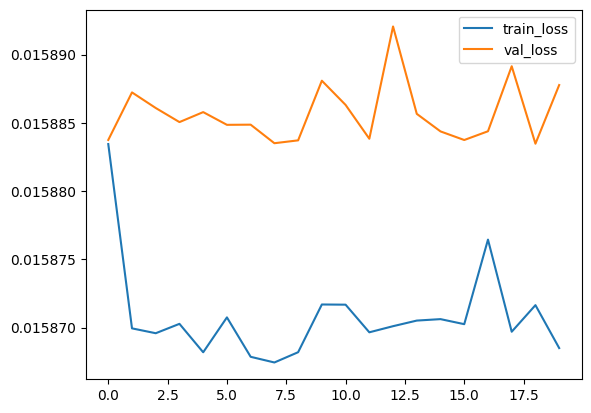

In [16]:
plt.figure(1)
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.legend()

## **Encoder-Decoder Arch**

In [17]:
# adapted from https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9454242

class CausalConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1):
        super(CausalConv1d, self).__init__()
        self.padding = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(in_channels, out_channels,
                              kernel_size, padding="valid", dilation=dilation)

    def forward(self, x):
        return self.conv(F.pad(x, (self.padding, 0)))


class GatedDCCBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1):
        super(GatedDCCBlock, self).__init__()
        self.dilated_conv = CausalConv1d(
            in_channels, 2 * out_channels, kernel_size, dilation=dilation)
        self.proj = CausalConv1d(out_channels, out_channels, 1)

    def forward(self, x):
        x = self.dilated_conv(x)
        x, gate = x.chunk(2, dim=1)
        z = torch.tanh(x) * torch.sigmoid(gate)
        return self.proj(z)


class EncoderDecoder(nn.Module):
    def __init__(self, in_channels=2,
                 out_channels=2,
                 hidden_channels=64,
                 residual_layers=5,
                 dilation__cycle_length=10):
        super(EncoderDecoder, self).__init__()
        self.input_projection = CausalConv1d(in_channels, hidden_channels, 1)
        self.norm = nn.BatchNorm1d(hidden_channels)
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        for i in range(residual_layers):
            self.encoder.extend([
                GatedDCCBlock(hidden_channels, hidden_channels, 3,
                              dilation=2**(i % dilation__cycle_length)),
                nn.MaxPool1d(2)
            ])
            self.decoder.extend([
                GatedDCCBlock(hidden_channels, hidden_channels, 3,
                              dilation=2**(i % dilation__cycle_length)),
                nn.ConvTranspose1d(
                    hidden_channels, hidden_channels, 2, stride=2)
            ])

        self.output_projection = nn.Conv1d(hidden_channels, out_channels, 1)

    def forward(self, x):
        x = self.input_projection(x)
        x = self.norm(x)
        # TODO: add skip connections
        for layer in self.encoder:
            x = layer(x) + x if isinstance(layer, GatedDCCBlock) else layer(x)
        for layer in self.decoder:
            x = layer(x) + x if isinstance(layer, GatedDCCBlock) else layer(x)
        return self.output_projection(x)

In [18]:
dataset = IQ2TargetDataset(
    X[train_idx], y[train_idx],
    metadata[train_idx])
train_ds, val_ds = random_split(
    dataset, [int(len(dataset)*0.8), len(dataset)-int(len(dataset)*0.8)])
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

In [19]:
model = EncoderDecoder(
    in_channels=2,  # number of channels in the IQ data
    out_channels=2,  # number of channels in the IQ data
    hidden_channels=64,  # number of hidden filters
    residual_layers=2,  # number of residual layers
    dilation__cycle_length=10  # cycle length of the dilation
).to(device)
optimizer = torch.optim.Adam(
    model.parameters(), lr=1e-3, weight_decay=5e-4)  # L2 regularization
criterion = nn.MSELoss()
tracker = Tracker('val_loss')

print(
    f'Model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} parameters')


history = {
    'train_loss': [],
    'val_loss': [],
}
if os.path.exists('./Models/best_encoder_decoder.pth'):
    model.load_state_dict(torch.load(
        './Models/best_encoder_decoder.pth', weights_only=True))
    print('Model loaded from ./Models/best_encoder_decoder.pth')
for epoch in range(NUM_EPOCHS):
    train_loss = train_one_epoch(model, optimizer, criterion, train_loader)
    val_loss = validate(model, criterion, val_loader)
    print(
        f'Epoch {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}')

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

    if tracker.operator(val_loss, tracker.best):
        tracker.best = val_loss
        torch.save(model.state_dict(), './Models/best_encoder_decoder.pth')
        print('Model saved with val loss:',
              val_loss, 'at ./Models/best_encoder_decoder.pth')

Model has 132,418 parameters
Epoch 0, Train Loss: 0.0038081495293160335, Val Loss: 0.002818358123768121
Model saved with val loss: 0.002818358123768121 at ./Models/best_encoder_decoder.pth
Epoch 1, Train Loss: 0.003444218923998618, Val Loss: 0.0030913586513171055
Epoch 2, Train Loss: 0.0033148052218772606, Val Loss: 0.0027902906998166477
Model saved with val loss: 0.0027902906998166477 at ./Models/best_encoder_decoder.pth
Epoch 3, Train Loss: 0.0032503599542517882, Val Loss: 0.0030674165697630747
Epoch 4, Train Loss: 0.0032292485756769515, Val Loss: 0.0027321856447088066
Model saved with val loss: 0.0027321856447088066 at ./Models/best_encoder_decoder.pth
Epoch 5, Train Loss: 0.003204818011346102, Val Loss: 0.0028128894816142167
Epoch 6, Train Loss: 0.00319256184107761, Val Loss: 0.0027433060233174314
Epoch 7, Train Loss: 0.003188511510441009, Val Loss: 0.002804424031452403
Epoch 8, Train Loss: 0.003196322634939704, Val Loss: 0.0030424907197117465
Epoch 9, Train Loss: 0.003165431268427

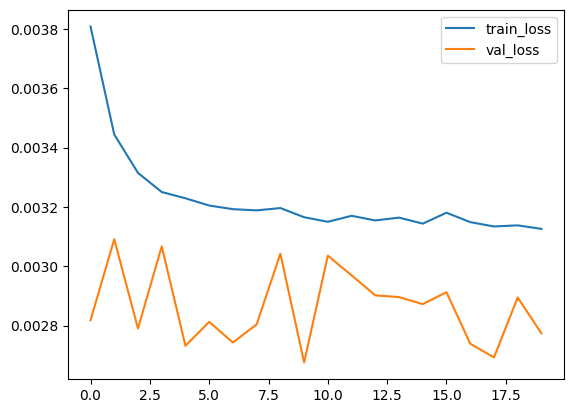

In [20]:
plt.figure(1)
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.legend()

## **Evaluation**

Evaluation will be measured based on the gains compared with random initialization stage before training

### **Denoiser**

In [21]:
test_ds = IQ2TargetDataset(X[test_idx], y[test_idx], metadata[test_idx],
                           data_transform=Denoiser_data_txfm, target_transform=Denoiser_target_txfm)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [23]:
random_init = Denoiser(hidden_feat=64).to(device)
trained_model = Denoiser(hidden_feat=64).to(device)
trained_model.load_state_dict(torch.load(
    './Models/best_denoiser.pth', weights_only=True))

random_init_loss = validate(random_init, criterion, test_loader)
trained_model_loss = validate(trained_model, criterion, test_loader)

print("The percentage improvement of the trained model over the random model is: ",
      (random_init_loss - trained_model_loss) / random_init_loss * 100)
print("Random Init Loss: ", random_init_loss)
print("Trained Model Loss: ", trained_model_loss)

The percentage improvement of the trained model over the random model is:  88.7846324908586
Random Init Loss:  0.1462698773714629
Trained Model Loss:  0.01640470430238003


In [24]:
reconstructed = {
    "denoiser": {
        "x": [],
        "y": [],
        "y_hat": [],
        "l": []
    },
    "encoder_decoder": {
        "x": [],
        "y": [],
        "y_hat": [],
        "l": []
    }
}

In [25]:
one_xb, one_yb, idx = next(iter(test_loader))
one_xb, one_yb = one_xb.to(device), one_yb.to(device)
one_yb_hat = trained_model(one_xb)
one_yb_hat = one_yb_hat.detach().squeeze().cpu().numpy()
one_xb = one_xb.detach().squeeze().cpu().numpy()
one_yb = one_yb.detach().squeeze().cpu().numpy()


reconstructed["denoiser"]["x"] = one_xb[0]
reconstructed["denoiser"]["y"] = one_yb[0]
reconstructed["denoiser"]["y_hat"] = one_yb_hat[0]
reconstructed["denoiser"]["l"] = list(
    labels)[int(test_ds.get_metadata(idx[0]))]

### **Encoder-Decoder**

In [26]:
test_ds = IQ2TargetDataset(X[test_idx], y[test_idx], metadata[test_idx])
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [27]:
random_init = EncoderDecoder(residual_layers=2).to(device)
trained_model = EncoderDecoder(residual_layers=2).to(device)
trained_model.load_state_dict(torch.load(
    './Models/best_encoder_decoder.pth', weights_only=True))

random_init_loss = validate(random_init, criterion, test_loader)
trained_model_loss = validate(trained_model, criterion, test_loader)

print("The percentage improvement of the trained model over the random model is: ",
      (random_init_loss - trained_model_loss) / random_init_loss * 100)
print("Random Init Loss: ", random_init_loss)
print("Trained Model Loss: ", trained_model_loss)

The percentage improvement of the trained model over the random model is:  90.40518696993746
Random Init Loss:  0.02833453747359189
Trained Model Loss:  0.002718645893524147


In [28]:
one_xb, one_yb, idx = next(iter(test_loader))
one_xb, one_yb = one_xb.to(device), one_yb.to(device)
one_yb_hat = trained_model(one_xb)
one_yb_hat = one_yb_hat.detach().cpu().numpy()
one_xb = one_xb.detach().cpu().numpy()
one_yb = one_yb.detach().cpu().numpy()

reconstructed["encoder_decoder"]["x"] = one_xb[0]
reconstructed["encoder_decoder"]["y"] = one_yb[0]
reconstructed["encoder_decoder"]["y_hat"] = one_yb_hat[0]
reconstructed["encoder_decoder"]["l"] = list(
    labels)[int(test_ds.get_metadata(idx[0]))]

## **Visualization**

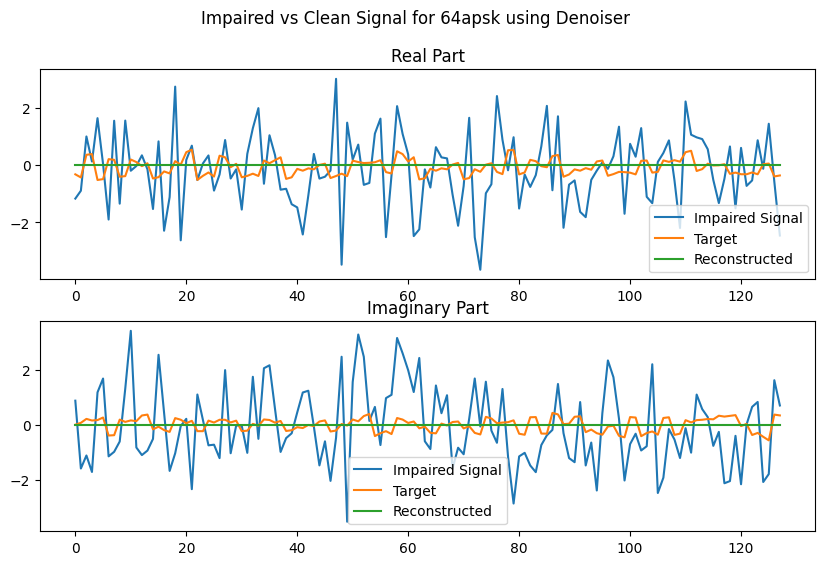

In [29]:
fig = plt.figure(figsize=(10, 6))
fig.suptitle('Impaired vs Clean Signal for ' +
             str(reconstructed["denoiser"]["l"]) + ' using Denoiser')
ax = fig.add_subplot(211)
ax.set_title('Real Part')
ax.plot(reconstructed["denoiser"]["x"][0], label='Impaired Signal')
ax.plot(reconstructed["denoiser"]["y"][0], label='Target')
ax.plot(reconstructed["denoiser"]["y_hat"][0], label='Reconstructed')
ax.legend()

ax = fig.add_subplot(212)
ax.set_title('Imaginary Part')
ax.plot(reconstructed["denoiser"]["x"][1], label='Impaired Signal')
ax.plot(reconstructed["denoiser"]["y"][1], label='Target')
ax.plot(reconstructed["denoiser"]["y_hat"][1], label='Reconstructed')
ax.legend()

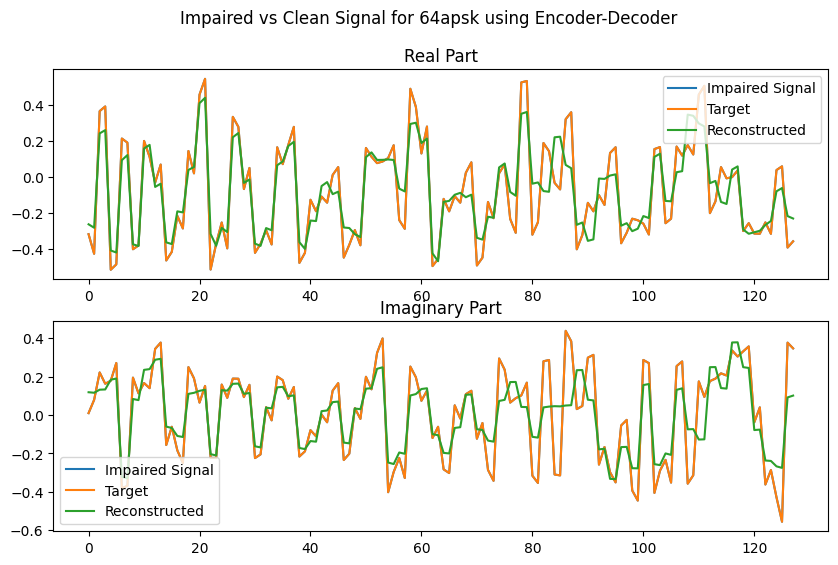

In [30]:
fig = plt.figure(figsize=(10, 6))
fig.suptitle('Impaired vs Clean Signal for ' +
             str(reconstructed["encoder_decoder"]["l"]) + ' using Encoder-Decoder')
ax = fig.add_subplot(211)
ax.set_title('Real Part')
ax.plot(reconstructed["encoder_decoder"]["x"][0], label='Impaired Signal')
ax.plot(reconstructed["encoder_decoder"]["y"][0], label='Target')
ax.plot(reconstructed["encoder_decoder"]["y_hat"][0], label='Reconstructed')
ax.legend()

ax = fig.add_subplot(212)
ax.set_title('Imaginary Part')
ax.plot(reconstructed["encoder_decoder"]["x"][1], label='Impaired Signal')
ax.plot(reconstructed["encoder_decoder"]["y"][1], label='Target')
ax.plot(reconstructed["encoder_decoder"]["y_hat"][1], label='Reconstructed')
ax.legend()

**All indications show that the Encoder-Decoder model is better suited for the signal reconstruction task**

### **Next steps**

- Add the missing layer of the Denoiser and carry out a final comparison
- Add the skip connections and fc layers for the Encoder-Decoder model
- Run experiments with more impairment and measure impact on training